In [319]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize

# Seperate Executions


In [534]:
import numpy as np
import matplotlib.pyplot as plt

## Pricing strategy

In [545]:
NUM_DAYS = 2000  # Total number of days
NUM_ROUNDS_PER_DAY = 10  # Number of rounds per day (e.g., auction rounds)
NUM_PRICES = 100  # Number of discrete prices for the pricing strategy
CHANGE_INTERVAL = 1  # Interval for changing the user buying probability distribution

CONVERSION_RATE_MEAN = 0.5  # Mean of the conversion rate (to model user's behavior)
CONVERSION_RATE_STD = 0.1  # Standard deviation of the conversion rate

In [546]:
class AdversarialPricingEnvironment:
    def __init__(self, num_arms, change_interval):
        self.num_arms = num_arms
        self.change_interval = change_interval
        self.t = 0
        self.buying_probabilities = self._generate_buying_probabilities()

    def _generate_buying_probabilities(self):
        return np.random.rand(self.num_arms)

    def reset(self):
        if self.t % self.change_interval == 0:
            self.buying_probabilities = self._generate_buying_probabilities()

    def round(self, a_t):
        prob = self.buying_probabilities[a_t]
        self.t += 1
        return np.random.rand() < prob


In [547]:
class AdversarialPricingEnvironment:
    def __init__(self, num_arms, change_interval, init_mean=0.5, std_dev=0.1):
        self.num_arms = num_arms
        self.change_interval = change_interval
        self.std_dev = std_dev
        self.t = 0
        self.means = np.ones(self.num_arms) * init_mean
        self.buying_probabilities = self._generate_buying_probabilities()

    def _generate_buying_probabilities(self):
        return np.clip(np.random.normal(self.means, self.std_dev), 0, 1)

    def reset(self):
        # Change the means over time to make the environment more adversarial
        if self.t % self.change_interval == 0:
            self.means = np.clip(self.means + np.random.normal(0, 0.01, size=self.num_arms), 0, 1)
            self.buying_probabilities = self._generate_buying_probabilities()

    def round(self, a_t):
        prob = self.buying_probabilities[a_t]
        self.t += 1
        return np.random.rand() < prob


In [548]:
class AdversarialPricingEnvironment:
    def __init__(self, num_arms, change_interval, function_family="sine"):
        self.num_arms = num_arms
        self.change_interval = change_interval
        self.t = 0
        self.parameters = np.random.rand(self.num_arms) * 2 * np.pi  # Initialize parameters
        self.buying_probabilities = self._generate_buying_probabilities(function_family)

    def _generate_buying_probabilities(self, function_family):
        if function_family == "sine":
            return np.clip(0.5 + 0.5 * np.sin(self.parameters), 0, 1)
    def reset(self, function_family="sine"):
        if self.t % self.change_interval == 0:
            # Adjust the parameters randomly to create changes over time
            self.parameters += np.random.uniform(-0.5, 0.5, self.num_arms)
            self.buying_probabilities = self._generate_buying_probabilities(function_family)

    def round(self, a_t):
        prob = self.buying_probabilities[a_t]
        self.t += 1
        return np.random.rand() < prob


In [549]:
class UCB1:
    def __init__(self, num_arms, T, reward_range=1):
        self.num_arms = num_arms
        self.T = T  # Total number of rounds
        self.reward_range = reward_range
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 0  # Current time step

    def select_arm(self):
        if self.t < self.num_arms:
            return self.t  # Play each arm once initially

        confidence_bounds = self.values + self.reward_range * np.sqrt(
            (2 * np.log(self.T)) / self.counts
        )
        return np.argmax(confidence_bounds)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        self.t += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        new_value = ((n - 1) / n) * value + (1 / n) * reward
        self.values[chosen_arm] = new_value


In [550]:
class EXP3Agent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.a_t = None
        self.x_t = np.ones(K)/K
        self.N_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t
    
    def update(self, l_t):
        l_t_tilde = l_t/self.x_t[self.a_t]
        self.weights[self.a_t] *= np.exp(-self.learning_rate*l_t_tilde)
        self.N_pulls[self.a_t] += 1
        self.t += 1


In [551]:
# Initialize environment
T = NUM_DAYS * NUM_ROUNDS_PER_DAY
env = AdversarialPricingEnvironment(num_arms=NUM_PRICES, change_interval=CHANGE_INTERVAL)

# Initialize agents
ucb_agent = UCB1(num_arms=NUM_PRICES, T=T)
exp3_agent = EXP3Agent(K=NUM_PRICES, learning_rate=0.1)

# Logging variables
ucb_rewards, exp3_rewards = [], []
ucb_regrets, exp3_regrets = [], []

ucb_total_rewards = exp3_total_rewards = 0
ucb_cumulative_regret = exp3_cumulative_regret = 0

for day in range(NUM_DAYS):
    env.reset()  # Update buying probabilities as per environment dynamics

    ucb_daily_reward = exp3_daily_reward = 0

    for round in range(NUM_ROUNDS_PER_DAY):
        # UCB1 Agent
        ucb_chosen_price = ucb_agent.select_arm()
        ucb_reward = env.round(ucb_chosen_price)
        ucb_agent.update(ucb_chosen_price, ucb_reward)
        ucb_daily_reward += ucb_reward

        # EXP3 Agent
        exp3_chosen_price = exp3_agent.pull_arm()
        exp3_reward = env.round(exp3_chosen_price)
        l_t = 1 - exp3_reward  # Loss is 1 - reward
        exp3_agent.update(l_t)
        exp3_daily_reward += exp3_reward

    ucb_total_rewards += ucb_daily_reward
    exp3_total_rewards += exp3_daily_reward

    # Compute daily regret
    optimal_reward = np.max(env.buying_probabilities) * NUM_ROUNDS_PER_DAY
    ucb_daily_regret = optimal_reward - ucb_daily_reward
    exp3_daily_regret = optimal_reward - exp3_daily_reward
    ucb_cumulative_regret += ucb_daily_regret
    exp3_cumulative_regret += exp3_daily_regret

    # Log rewards and regrets
    ucb_rewards.append(ucb_daily_reward)
    exp3_rewards.append(exp3_daily_reward)
    ucb_regrets.append(ucb_cumulative_regret)
    exp3_regrets.append(exp3_cumulative_regret)

print(f"UCB1 - Total rewards: {ucb_total_rewards}, Cumulative regret: {ucb_cumulative_regret}")
print(f"EXP3 - Total rewards: {exp3_total_rewards}, Cumulative regret: {exp3_cumulative_regret}")


UCB1 - Total rewards: 16309, Cumulative regret: 3681.8191446754413
EXP3 - Total rewards: 16122, Cumulative regret: 3868.819144675445


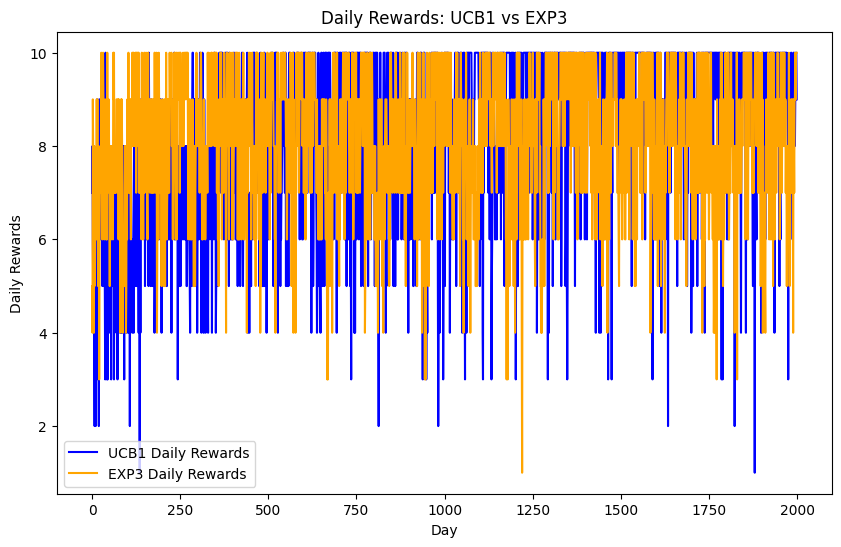

In [552]:
plt.figure(figsize=(10, 6))
plt.plot(range(NUM_DAYS), ucb_rewards, label='UCB1 Daily Rewards', color='blue')
plt.plot(range(NUM_DAYS), exp3_rewards, label='EXP3 Daily Rewards', color='orange')
plt.xlabel('Day')
plt.ylabel('Daily Rewards')
plt.title('Daily Rewards: UCB1 vs EXP3')
plt.legend()
plt.show()


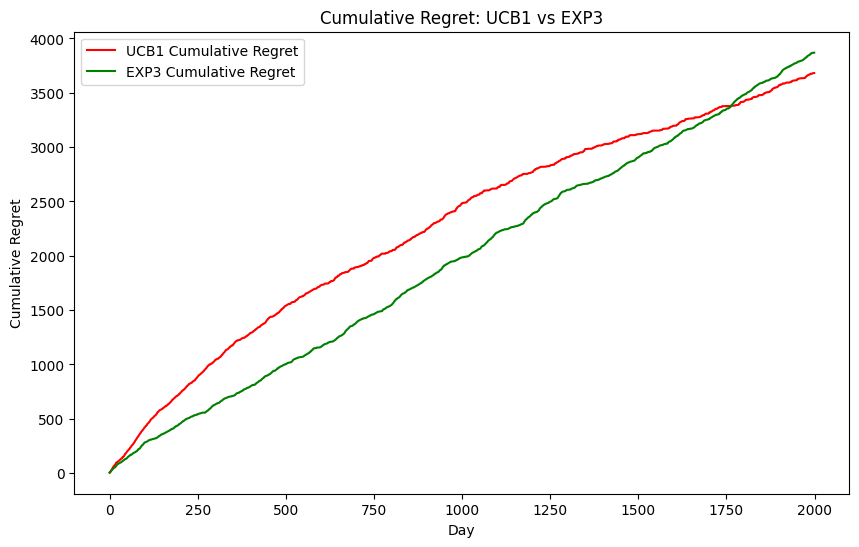

In [553]:
plt.figure(figsize=(10, 6))
plt.plot(range(NUM_DAYS), ucb_regrets, label='UCB1 Cumulative Regret', color='red')
plt.plot(range(NUM_DAYS), exp3_regrets, label='EXP3 Cumulative Regret', color='green')
plt.xlabel('Day')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret: UCB1 vs EXP3')
plt.legend()
plt.show()


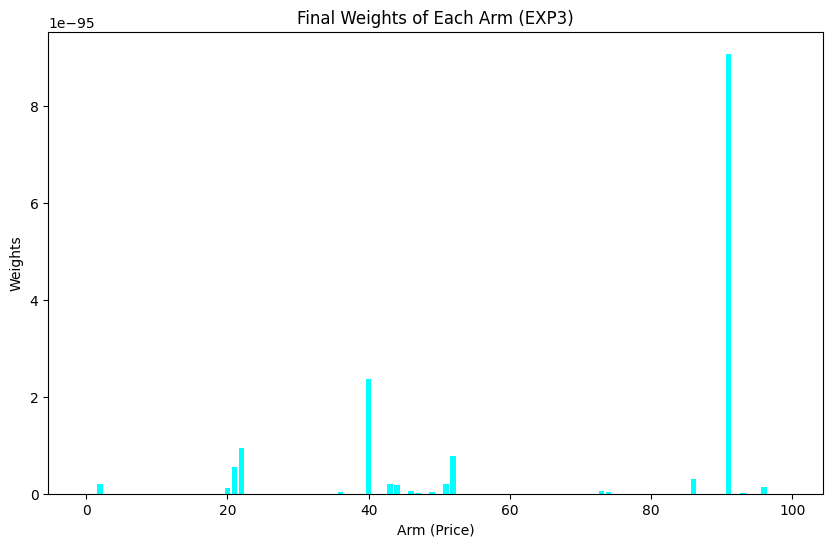

In [554]:
plt.figure(figsize=(10, 6))
plt.bar(range(NUM_PRICES), exp3_agent.weights, color='cyan')
plt.xlabel('Arm (Price)')
plt.ylabel('Weights')
plt.title('Final Weights of Each Arm (EXP3)')
plt.show()


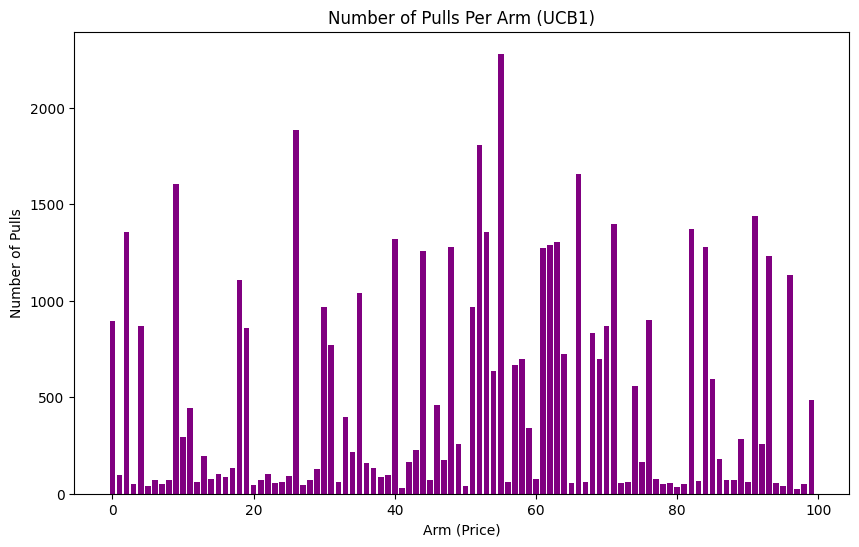

In [276]:
plt.figure(figsize=(10, 6))
plt.bar(range(NUM_PRICES), ucb_agent.counts, color='purple')
plt.xlabel('Arm (Price)')
plt.ylabel('Number of Pulls')
plt.title('Number of Pulls Per Arm (UCB1)')
plt.show()


## Bidding Strategy

In [454]:
class AdversarialFirstPriceAuction:
    def __init__(self, num_bidders, num_bids, change_interval, ctrs, init_mean=0.2, std_dev=0.1):
        self.num_bidders = num_bidders
        self.num_bids = num_bids
        self.change_interval = change_interval
        self.ctrs = ctrs
        self.std_dev = std_dev
        self.t = 0
        self.means = np.ones(self.num_bids) * init_mean 
        self.bidding_distribution = self._generate_bidding_distribution()

    def _generate_bidding_distribution(self):
        # Use sinusoidal function to make the environment more dynamic and adversarial
        return np.clip(0.5 + 0.5 * np.sin(self.means * 2 * np.pi * self.t / self.change_interval), 0, 1)

    def reset(self):
        # Change the means with a sinusoidal pattern over time
        if self.t % self.change_interval == 0:
            self.means = np.clip(self.means + np.sin(np.random.normal(0, 0.02, size=self.num_bids)), 0, 1)
            self.bidding_distribution = self._generate_bidding_distribution()

    def round(self, bid):
        # Simulate the auction round
        competitors_bids = np.random.choice(self.bidding_distribution, size=self.num_bidders)
        max_bid = np.max(competitors_bids)
        win = bid > max_bid
        payment = bid if win else 0
        self.t += 1
        return max_bid, win, payment


In [455]:
class HedgeAgent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K) / K
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights / sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t

    def update(self, l_t):
        self.weights *= np.exp(-self.learning_rate * l_t)
        self.t += 1


In [456]:
class FFMultiplicativePacingAgent:
    def __init__(self, bids_set, valuation, budget, T, eta):
        self.bids_set = bids_set
        self.K = len(bids_set)
        # Increased exploration by adjusting the learning rate
        self.hedge = HedgeAgent(self.K, np.sqrt(np.log(self.K) / T) * 2) 
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget / self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.bids_set[self.hedge.pull_arm()]

    def update(self, f_t, c_t, m_t):
        f_t_full = np.array([(self.valuation - b) * int(b >= m_t) for b in self.bids_set])
        c_t_full = np.array([b * int(b >= m_t) for b in self.bids_set])
        L = f_t_full - self.lmbd * (c_t_full - self.rho)
        range_L = 2 + (1 - self.rho) / self.rho
        self.hedge.update((2 - L) / range_L)
        self.lmbd = np.clip(self.lmbd - self.eta * (self.rho - c_t), 0, 1 / self.rho)
        self.budget -= c_t


In [474]:
NUM_BIDDERS = 10
NUM_BIDS = 100
CHANGE_INTERVAL = 1 
NUM_DAYS = 5000
INITIAL_BUDGET = 4000
valuation = 1.0

In [475]:
ctrs = np.ones(NUM_BIDDERS + 1)  # Assume CTR = 1 
env = AdversarialFirstPriceAuction(num_bidders=NUM_BIDDERS, num_bids=NUM_BIDS, change_interval=CHANGE_INTERVAL, ctrs=ctrs)
bidding_agent = FFMultiplicativePacingAgent(bids_set=np.linspace(0, 1, NUM_BIDS), valuation=valuation, budget=INITIAL_BUDGET, T=NUM_DAYS, eta=0.05)

total_rewards = 0
cumulative_rewards = []
cumulative_payments = []
total_payment = 0
bids_chosen = []
bid_frequencies = np.zeros(NUM_BIDS)
wins = []
rewards_over_time = []
win_count = 0

for day in range(NUM_DAYS):
    env.reset()  # Reset the adversarial environment periodically

    # Agent makes a bid
    agent_bid = bidding_agent.bid()

    # Track bids chosen
    bids_chosen.append(agent_bid)
    bid_index = np.where(np.linspace(0, 1, NUM_BIDS) == agent_bid)[0][0]
    bid_frequencies[bid_index] += 1

    max_competitor_bid, win, payment = env.round(agent_bid)

    reward = valuation - payment if win else 0
    bidding_agent.update(reward, payment, max_competitor_bid)

    total_rewards += reward
    total_payment += payment
    cumulative_rewards.append(total_rewards)
    cumulative_payments.append(total_payment) 
    wins.append(win)  
    rewards_over_time.append(reward)  

    if win:
        win_count += 1


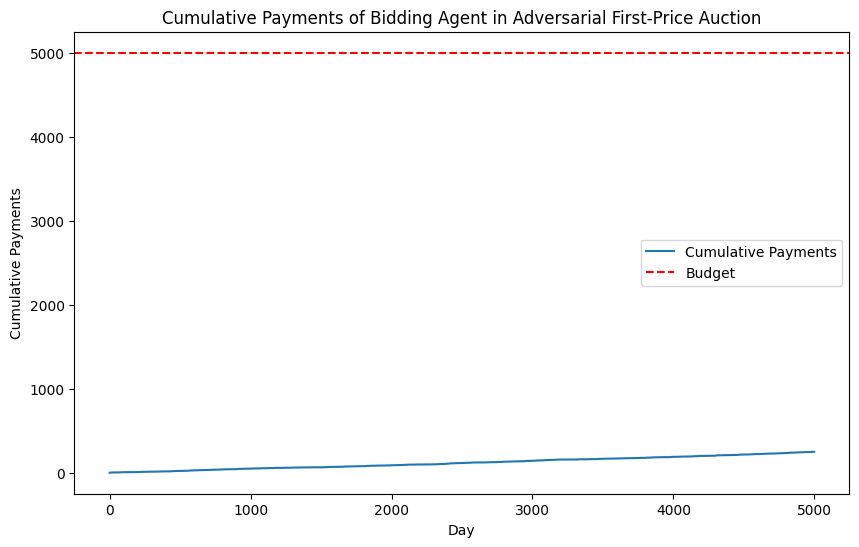

In [476]:
# Plot cumulative payments
plt.figure(figsize=(10, 6))
plt.plot(cumulative_payments, label="Cumulative Payments")
plt.axhline(initial_budget, color='red', linestyle='--', label='Budget')
plt.title("Cumulative Payments of Bidding Agent in Adversarial First-Price Auction")
plt.xlabel("Day")
plt.ylabel("Cumulative Payments")
plt.legend()
plt.show()


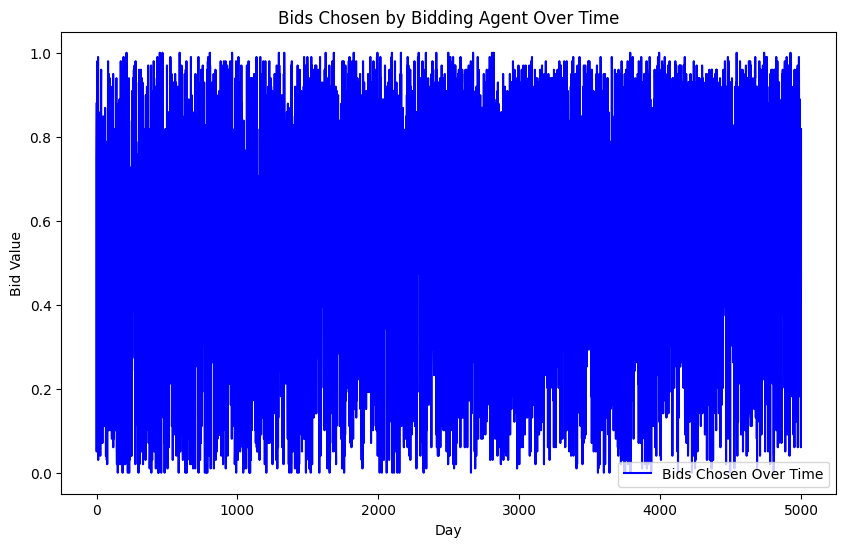

In [477]:
# Plot bids chosen over time
plt.figure(figsize=(10, 6))
plt.plot(bids_chosen, label="Bids Chosen Over Time", color="blue")
plt.title("Bids Chosen by Bidding Agent Over Time")
plt.xlabel("Day")
plt.ylabel("Bid Value")
plt.legend()
plt.show()


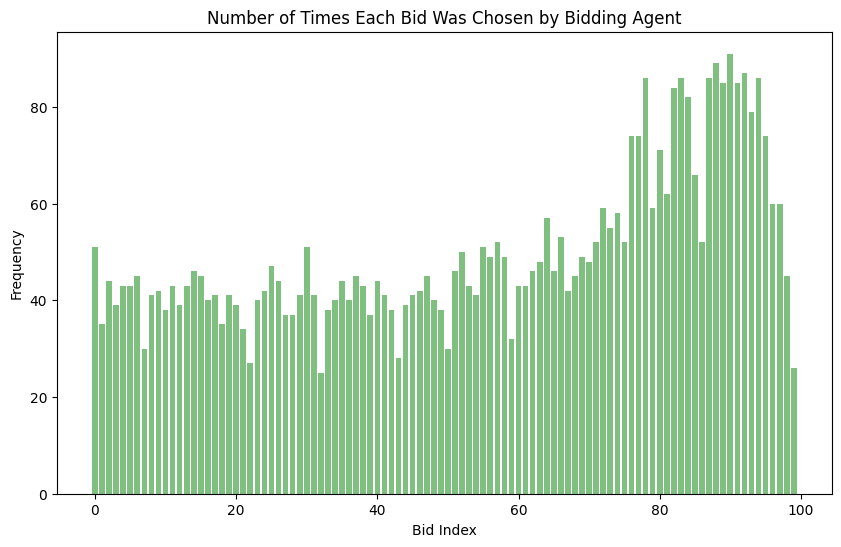

In [478]:
# Plot frequency of bids chosen
plt.figure(figsize=(10, 6))
plt.bar(np.arange(NUM_BIDS), bid_frequencies, color="green", alpha=0.5)
plt.title("Number of Times Each Bid Was Chosen by Bidding Agent")
plt.xlabel("Bid Index")
plt.ylabel("Frequency")
plt.show()


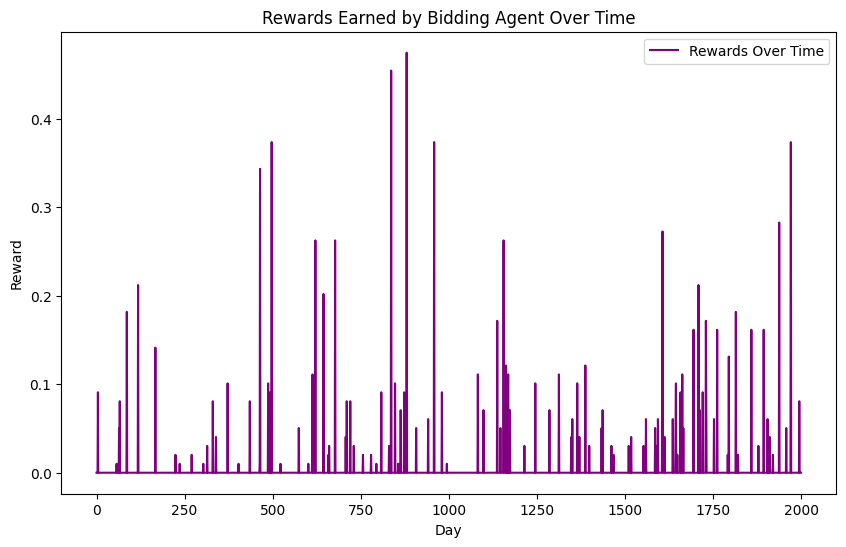

In [467]:
# Plot rewards over time
plt.figure(figsize=(10, 6))
plt.plot(rewards_over_time, color='purple', label="Rewards Over Time")
plt.title("Rewards Earned by Bidding Agent Over Time")
plt.xlabel("Day")
plt.ylabel("Reward")
plt.legend()
plt.show()


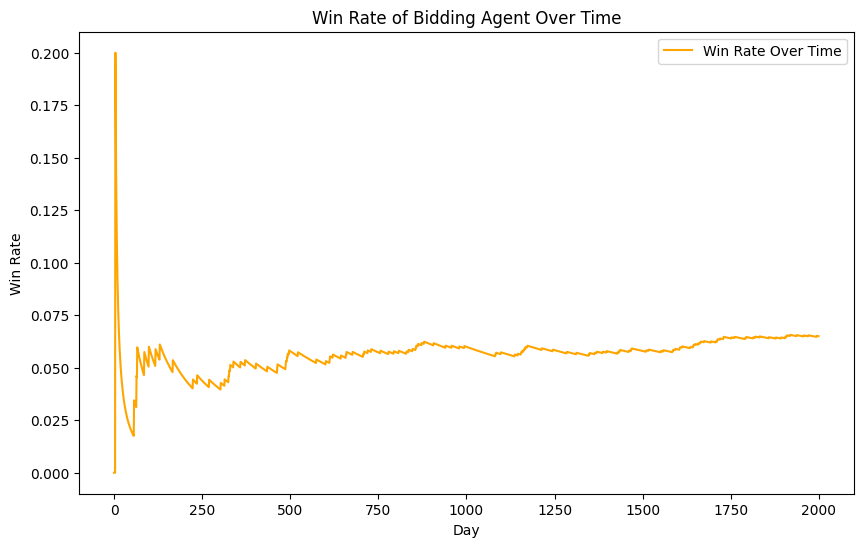

In [468]:
# Plot win rate over time
win_rate = np.cumsum(wins) / np.arange(1, NUM_DAYS + 1)
plt.figure(figsize=(10, 6))
plt.plot(win_rate, color='orange', label="Win Rate Over Time")
plt.title("Win Rate of Bidding Agent Over Time")
plt.xlabel("Day")
plt.ylabel("Win Rate")
plt.legend()
plt.show()


## Interaction

### Environment

In [583]:
class AdversarialPricingEnvironment:
    def __init__(self, num_arms, change_interval, function_family="sine"):
        self.num_arms = num_arms
        self.change_interval = change_interval
        self.t = 0
        self.parameters = np.random.rand(self.num_arms) * 2 * np.pi  
        self.buying_probabilities = self._generate_buying_probabilities(function_family)

    def _generate_buying_probabilities(self, function_family):
        if function_family == "sine":
            return np.clip(0.5 + 0.5 * np.sin(self.parameters), 0, 1)
    def reset(self, function_family="sine"):
        if self.t % self.change_interval == 0:
            # Adjust the parameters randomly to create changes over time
            self.parameters += np.random.uniform(-0.5, 0.5, self.num_arms)
            self.buying_probabilities = self._generate_buying_probabilities(function_family)

    def round(self, a_t):
        prob = self.buying_probabilities[a_t]
        self.t += 1
        return np.random.rand() < prob


In [528]:
class AdversarialFirstPriceAuction:
    def __init__(self, num_bidders, num_bids, change_interval, ctrs, init_mean=0.2, std_dev=0.1):
        self.num_bidders = num_bidders
        self.num_bids = num_bids
        self.change_interval = change_interval
        self.ctrs = ctrs
        self.std_dev = std_dev
        self.t = 0
        self.means = np.ones(self.num_bids) * init_mean 
        self.bidding_distribution = self._generate_bidding_distribution()

    def _generate_bidding_distribution(self):
        return np.clip(0.5 + 0.5 * np.sin(self.means * 2 * np.pi * self.t / self.change_interval), 0, 1)

    def reset(self):
        if self.t % self.change_interval == 0:
            self.means = np.clip(self.means + np.sin(np.random.normal(0, 0.02, size=self.num_bids)), 0, 1)
            self.bidding_distribution = self._generate_bidding_distribution()

    def round(self, bid):
        competitors_bids = np.random.choice(self.bidding_distribution, size=self.num_bidders)
        max_bid = np.max(competitors_bids)
        win = bid > max_bid
        payment = bid if win else 0
        self.t += 1
        return max_bid, win, payment


### Agents

In [612]:
class EXP3Agent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.a_t = None
        self.x_t = np.ones(K) / K
        self.N_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights / sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t

    def update(self, l_t):
        l_t_tilde = l_t / self.x_t[self.a_t]
        self.weights[self.a_t] *= np.exp(-self.learning_rate * l_t_tilde)
        self.N_pulls[self.a_t] += 1
        self.t += 1

class HedgeAgent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K) / K
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights / sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t

    def update(self, l_t):
        self.weights *= np.exp(-self.learning_rate * l_t)
        self.t += 1

class FFMultiplicativePacingAgent:
    def __init__(self, bids_set, valuation, budget, T, eta, exploration_threshold=0.1):
        self.bids_set = bids_set
        self.K = len(bids_set)
        self.hedge = HedgeAgent(self.K, np.sqrt(np.log(self.K) / T) * 2)  
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget / self.T
        self.lmbd = 1
        self.exploration_threshold = exploration_threshold  # New exploration threshold for dynamic adjustment
        self.t = 0
        self.loss_history = []  

    def bid(self):
        if self.budget < 1:
            return 0
        
        # Dynamic Exploration: if the loss is high for recent rounds, encourage more exploration
        # like a sliding window
        recent_losses = np.mean(self.loss_history[-10:]) if len(self.loss_history) > 5 else 0
        exploration_factor = 1 + min(recent_losses, self.exploration_threshold)
        
        # Adjust learning rate dynamically based on recent performance
        return self.bids_set[self.hedge.pull_arm()] * exploration_factor

    def update(self, f_t, c_t, m_t):
        f_t_full = np.array([(self.valuation - b) * int(b >= m_t) for b in self.bids_set])
        c_t_full = np.array([b * int(b >= m_t) for b in self.bids_set])
        L = f_t_full - self.lmbd * (c_t_full - self.rho)
        range_L = 2 + (1 - self.rho) / self.rho
        self.hedge.update((2 - L) / range_L)
        
        # Keep track of the performance for dynamic exploration
        loss = 1 - np.max(f_t_full)
        self.loss_history.append(loss)
        
        self.lmbd = np.clip(self.lmbd - self.eta * (self.rho - c_t), 0, 1 / self.rho)
        self.budget -= c_t



In [615]:
NUM_DAYS = 2000
NUM_ROUNDS_PER_DAY = 10
NUM_PRICES = 50
NUM_BIDDERS = 10
NUM_BIDS = 50
CHANGE_INTERVAL = 1
INITIAL_BUDGET = 5000
valuation = 1.0
T = NUM_DAYS * NUM_ROUNDS_PER_DAY

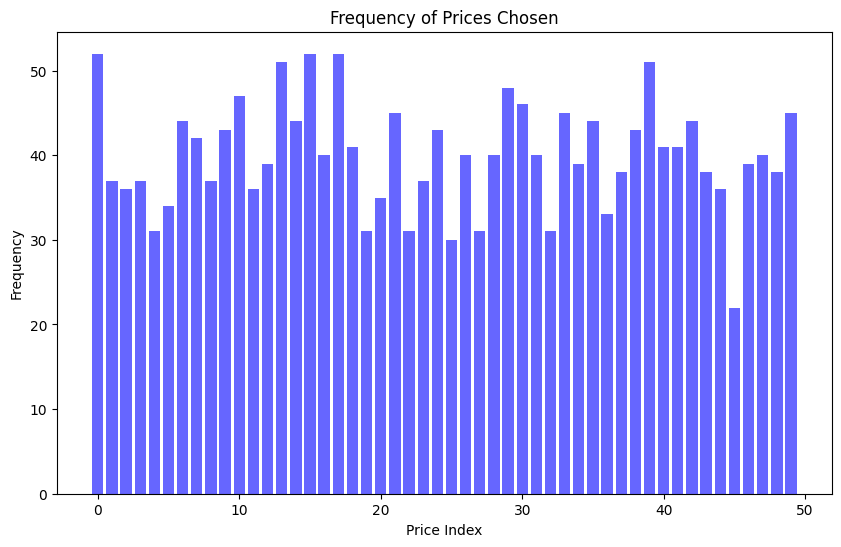

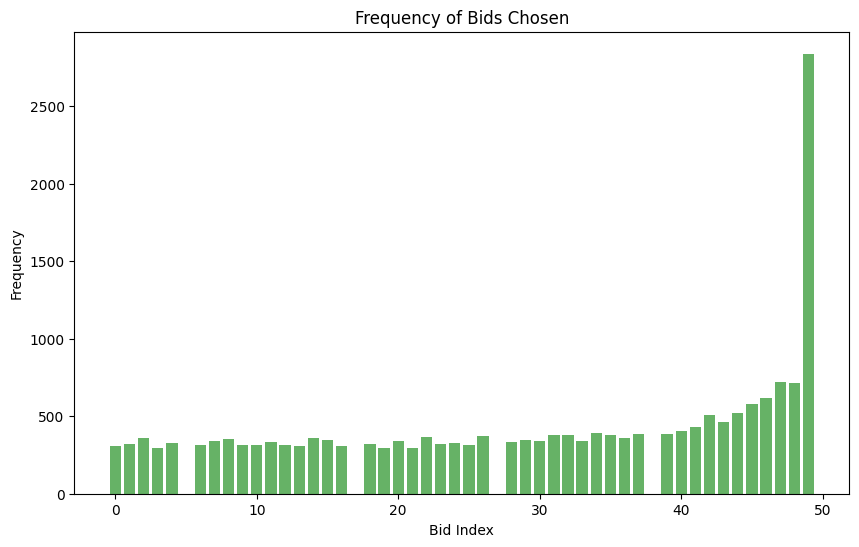

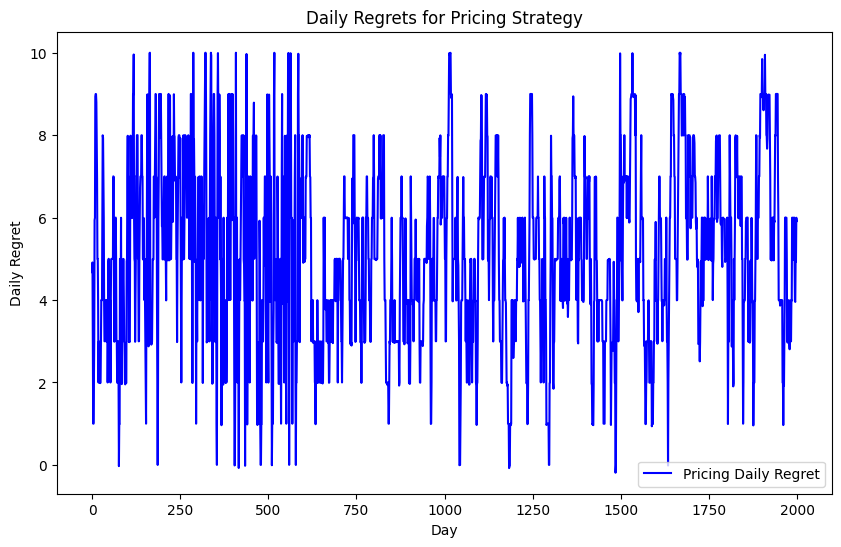

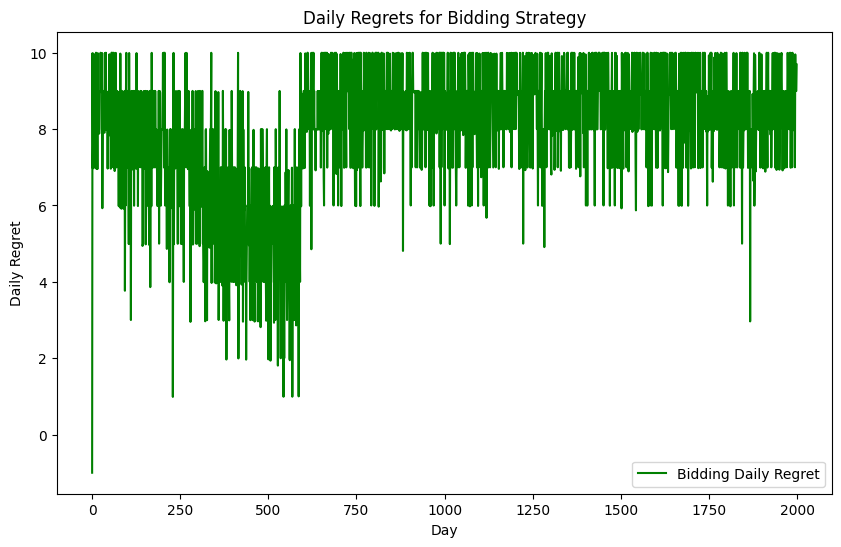

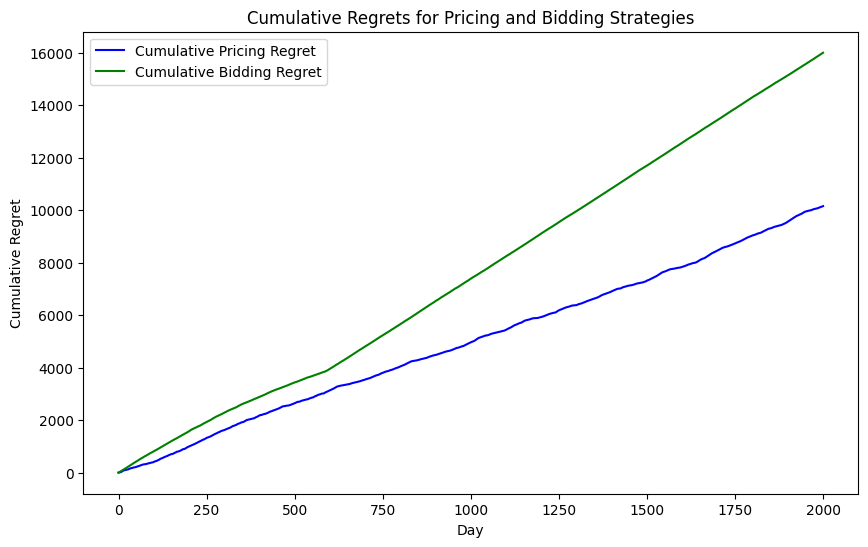

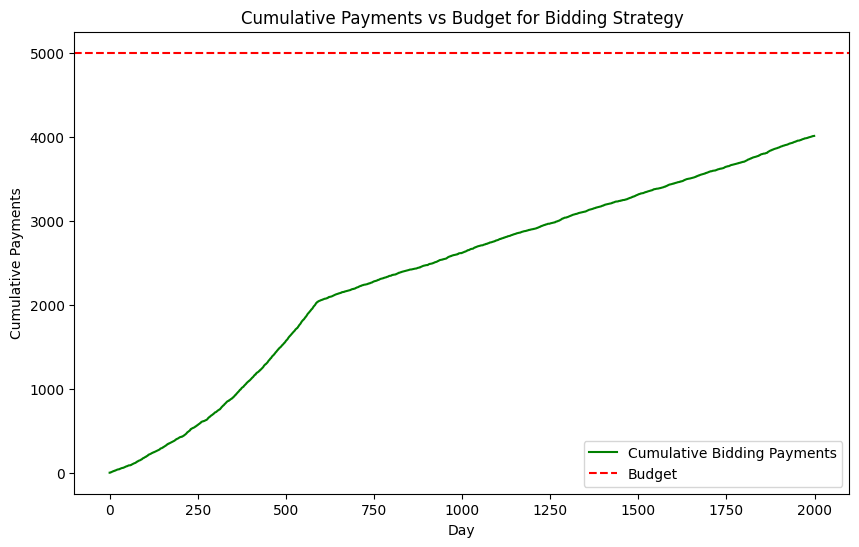

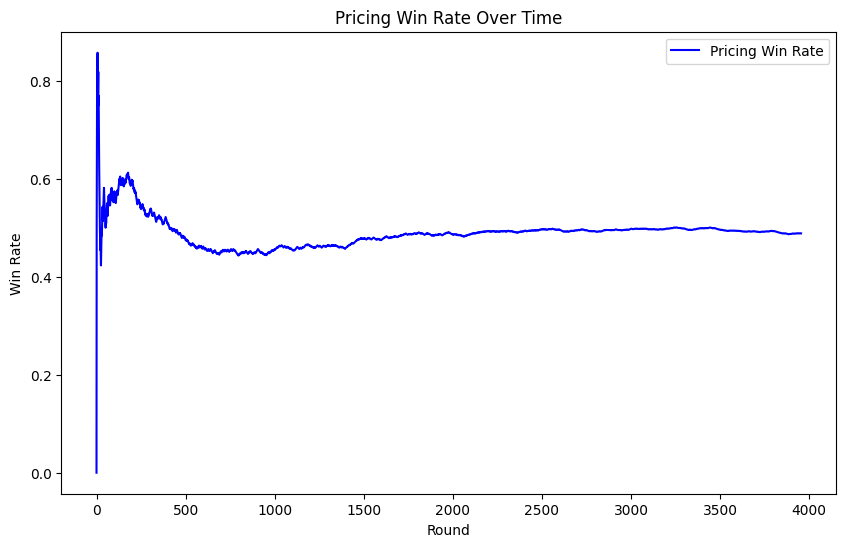

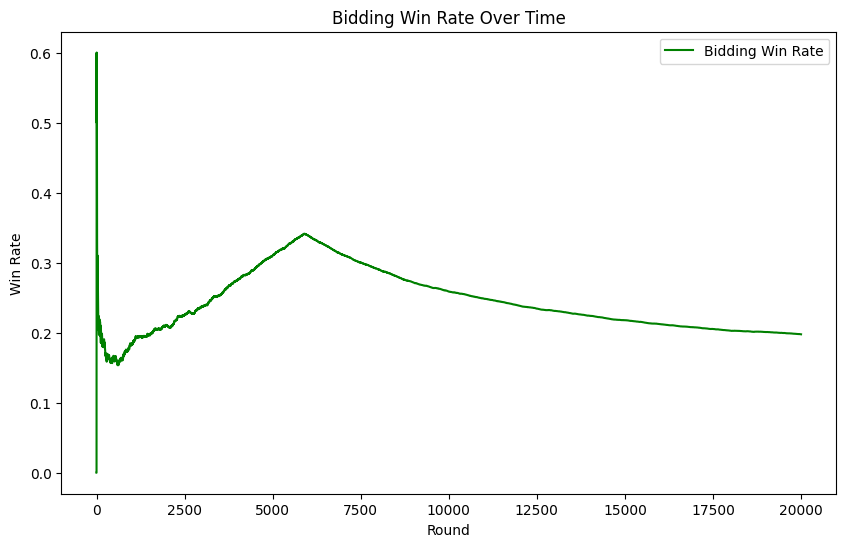

In [617]:
# Initialize the environments
pricing_env = AdversarialPricingEnvironment(num_arms=NUM_PRICES, change_interval=CHANGE_INTERVAL)
bidding_env = AdversarialFirstPriceAuction(num_bidders=NUM_BIDDERS, num_bids=NUM_BIDS, change_interval=CHANGE_INTERVAL, ctrs=np.ones(NUM_BIDDERS + 1))

# Initialize the agents
exp3_pricing_agent = EXP3Agent(K=NUM_PRICES, learning_rate=0.1)
bidding_agent = FFMultiplicativePacingAgent(bids_set=np.linspace(0, 1, NUM_BIDS), valuation=valuation, budget=INITIAL_BUDGET, T=NUM_DAYS, eta=0.05)


# Logging variables
total_bidding_payment = 0
cumulative_bidding_payments = []
pricing_win_count = 0
bidding_win_count = 0

pricing_frequencies = np.zeros(NUM_PRICES)
bids_frequencies = np.zeros(NUM_BIDS)
pricing_wins = []
bidding_wins = []

pricing_regrets = []
bidding_regrets = []

for day in range(NUM_DAYS):
    # Reset environments
    pricing_env.reset()
    bidding_env.reset()

    # Each day, the company chooses a price
    chosen_price = exp3_pricing_agent.pull_arm()
    pricing_frequencies[chosen_price] += 1

    # Initialize daily payments and regrets
    daily_bidding_payment = 0

    # Multiple auctions (rounds) happen during the day
    for round in range(NUM_ROUNDS_PER_DAY):
        # Bidding Strategy: Multiplicative Pacing
        agent_bid = bidding_agent.bid()
        
        # Find the closest index to the agent's bid
        bid_index = np.abs(np.linspace(0, 1, NUM_BIDS) - agent_bid).argmin()
        bids_frequencies[bid_index] += 1
        
        # The auction environment
        max_competitor_bid, win, payment = bidding_env.round(agent_bid)
        
        # If the company wins the auction
        if win:
            # The ad is shown and the user may buy the product based on the price p
            if pricing_env.round(chosen_price):  # A user buys if the ad is clicked based on price
                pricing_wins.append(1)  # Successful sale
            else:
                pricing_wins.append(0)
            bidding_wins.append(1)
        else:
            bidding_wins.append(0)
    
        # Track bidding payments
        daily_bidding_payment += payment
    
        # Update bidding agent (reward in bidding is based on winning and paying the correct amount)
        bidding_reward = valuation - payment if win else 0
        bidding_agent.update(bidding_reward, payment, max_competitor_bid)


    # Update cumulative payments
    total_bidding_payment += daily_bidding_payment
    cumulative_bidding_payments.append(total_bidding_payment)

    # Calculate daily regrets
    optimal_pricing_reward = np.max(pricing_env.buying_probabilities) * NUM_ROUNDS_PER_DAY
    optimal_bidding_reward = np.max(bidding_env.bidding_distribution) * NUM_ROUNDS_PER_DAY

    pricing_regret = optimal_pricing_reward - np.sum(pricing_wins[-NUM_ROUNDS_PER_DAY:])  # regret over the day
    bidding_regret = optimal_bidding_reward - np.sum(bidding_wins[-NUM_ROUNDS_PER_DAY:])

    pricing_regrets.append(pricing_regret)
    bidding_regrets.append(bidding_regret)

# Compute cumulative regrets for both pricing and bidding
cumulative_pricing_regrets = np.cumsum(pricing_regrets)
cumulative_bidding_regrets = np.cumsum(bidding_regrets)

# Plot frequency of prices chosen
plt.figure(figsize=(10, 6))
plt.bar(np.arange(NUM_PRICES), pricing_frequencies, color="blue", alpha=0.6)
plt.xlabel("Price Index")
plt.ylabel("Frequency")
plt.title("Frequency of Prices Chosen")
plt.show()

# Plot frequency of bids chosen
plt.figure(figsize=(10, 6))
plt.bar(np.arange(NUM_BIDS), bids_frequencies, color="green", alpha=0.6)
plt.xlabel("Bid Index")
plt.ylabel("Frequency")
plt.title("Frequency of Bids Chosen")
plt.show()

# Plot daily regrets for pricing
plt.figure(figsize=(10, 6))
plt.plot(pricing_regrets, label="Pricing Daily Regret", color="blue")
plt.xlabel("Day")
plt.ylabel("Daily Regret")
plt.legend()
plt.title("Daily Regrets for Pricing Strategy")
plt.show()

# Plot daily regrets for bidding
plt.figure(figsize=(10, 6))
plt.plot(bidding_regrets, label="Bidding Daily Regret", color="green")
plt.xlabel("Day")
plt.ylabel("Daily Regret")
plt.legend()
plt.title("Daily Regrets for Bidding Strategy")
plt.show()

# Plot cumulative regrets for pricing and bidding strategies
plt.figure(figsize=(10, 6))
plt.plot(cumulative_pricing_regrets, label="Cumulative Pricing Regret", color="blue")
plt.plot(cumulative_bidding_regrets, label="Cumulative Bidding Regret", color="green")
plt.xlabel("Day")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.title("Cumulative Regrets for Pricing and Bidding Strategies")
plt.show()

# Plot cumulative payments vs budget for bidding strategy
plt.figure(figsize=(10, 6))
plt.plot(cumulative_bidding_payments, label="Cumulative Bidding Payments", color="green")
plt.axhline(INITIAL_BUDGET, color='red', linestyle='--', label='Budget')
plt.xlabel("Day")
plt.ylabel("Cumulative Payments")
plt.legend()
plt.title("Cumulative Payments vs Budget for Bidding Strategy")
plt.show()

# Compute cumulative win rates for pricing and bidding
pricing_win_rate = np.cumsum(pricing_wins) / np.arange(1, len(pricing_wins) + 1)
bidding_win_rate = np.cumsum(bidding_wins) / np.arange(1, len(bidding_wins) + 1)

# Plot pricing win rate
plt.figure(figsize=(10, 6))
plt.plot(pricing_win_rate, label="Pricing Win Rate", color="blue")
plt.xlabel("Round")
plt.ylabel("Win Rate")
plt.legend()
plt.title("Pricing Win Rate Over Time")
plt.show()

# Plot bidding win rate
plt.figure(figsize=(10, 6))
plt.plot(bidding_win_rate, label="Bidding Win Rate", color="green")
plt.xlabel("Round")
plt.ylabel("Win Rate")
plt.legend()
plt.title("Bidding Win Rate Over Time")
plt.show()

